<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/NN-online/blob/main/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional Generative Adversarial Network

### Generator and Discriminator as Adversaries

In this exercise we build __two__ neural networks, a __generator__ and a __discrimintor__, that act as __adversaries__. The generator will generate images of digits to fool the discriminator and the discriminator tries to tell the fake (generated) from the real (from the MNIST dataset).

The image below shows our setup which can be summarized as follows

1. The generator generates a fake image.
1. The fake image, along with a real one, are fed to the discriminator.
1. The discriminator has to predict if an image is real (1) or fake (0)
1. Both predictions of the discriminator are fed back into the discriminator and the fake prediction into the generator.
1. The losses are as follows:
a. For the generator: a small loss means the more fakes are fooling the discriminator, i.e. the discriminator is labeling the fakes as real (1)
b. For the discriminator: combine how well it is detecting reals (1) and fakes(0)


![image](figures/gan.png)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
tf.__version__
from IPython import display


### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data. Scale the pixel values for better stability/convergence

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images=train_images/255.

In [3]:
train_images.shape

(60000, 28, 28, 1)

### Create a suffled dataset with batches

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Batch Normalization
In the presence of ReLU like activations batch normalization can help with the stability and convergence of the model. For a given __feature__ the data is normalized (center around the mean and scaled by the standard deviation).

Example

In [5]:
a=np.array([[1,2,3],[4,5,6],[7,8,9]]).astype('float32')
print(np.mean(a,axis=1))
print(np.std(a,axis=1))
bn=layers.BatchNormalization()
bn(a,training=True)

[2. 5. 8.]
[0.8164966 0.8164966 0.8164966]


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[-1.2246428, -1.2246429, -1.2246428],
       [ 0.       ,  0.       ,  0.       ],
       [ 1.2246428,  1.2246428,  1.224643 ]], dtype=float32)>

## The models

### Generator

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    #START upsampling
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # the sigmoid activation has NO probabilistic interpretation, 
    # it used just to scale the output in the interval [0,1]
    # Like the real images
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))

    return model

### Discriminator

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(28,28,1)))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [8]:
generator = make_generator_model()
discriminator=make_discriminator_model()

## Define the loss and optimizers

Define loss functions and optimizers for both models. 

In [9]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

It is __important__ to note that the generator loss is computed over the __discriminator__'s output for "fake" images __NOT__ the generator's output

In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

We would like for the two model to learn at the same rate

In [12]:
learning_rate=0.0005
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [13]:
checkpoint_dir='c:/Users/hikmat/Downloads/training_checkpoints'
checkpoint_prefix = 'c:/Users/hikmat/Downloads/training_checkpoints/ckpt'
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [14]:
EPOCHS = 50
noise_dim = 100

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.
### Single step learning

In [15]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Run the train_step method a number of EPOCHS. At the end of each epoch use the trained generator to generate images and plot them.

In [16]:
def train(dataset, epochs):
  for epoch in range(epochs):

    for image_batch in dataset:
      train_step(image_batch)

    # Display a sample of generated images
    # after each epoch
    display.clear_output(wait=True)
    plot_images(generator,epoch)

    # Save the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)


### Function to generate and plot the images


In [17]:
def plot_images(model,epoch):
  nsamples=24
  ## generate random vectors for 
  ## nsamples images
  ran = tf.random.normal([nsamples, noise_dim])
  predictions=model.predict(ran)

  fig = plt.figure(figsize=(4,nsamples//4))
  #fig.tight_layout()
  plt.subplots_adjust( wspace=0.2, hspace=0.2)

  for i in range(predictions.shape[0]):
      t=fig.add_subplot(4, nsamples//4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray_r')
      plt.axis('off')
  fig.suptitle("epoch"+str(epoch))
  plt.show()

## Main loop
This model needs at least 100 epochs to start generating decent looking digits.
Each epoch can take between 6 seconds and 2 minutes depending on the used GPU/CPU

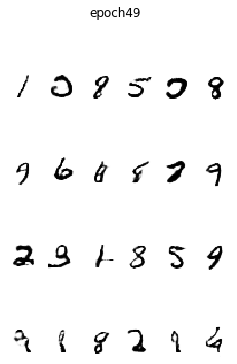

In [18]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
train(train_dataset, EPOCHS)